In [1]:
!pip install sacremoses

In [2]:
import numpy as np
import pandas as pd
from tabulate import tabulate

from datasets import load_dataset
from huggingface_hub import list_datasets
from sacremoses import MosesTokenizer, MosesDetokenizer

from collections import defaultdict, Counter
from itertools import pairwise

dataset_name = "ufal/npfl147"

/mnt/disk/patrik/nlp/.venv_nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = {
    "cs": load_dataset(dataset_name, "cs"),
    "en": load_dataset(dataset_name, "en"),
    "sk": load_dataset(dataset_name, "sk"),
}

moses_tokenizer = {
    "cs": MosesTokenizer(lang="cs"),
    "en": MosesTokenizer(lang="en"),
    "sk": MosesTokenizer(lang="sk"),
}

corpus_full = {
    lang: "".join(dataset[lang]["train"]["text"]) for lang in dataset.keys()
}

corpus_training = {
    lang: "".join(dataset[lang]["train"]["text"][:700]) for lang in dataset.keys()
}

corpus_heldout = {
    lang: "".join(dataset[lang]["train"]["text"][700:900]) for lang in dataset.keys()
}

corpus_test = {
    lang: "".join(dataset[lang]["train"]["text"][900:]) for lang in dataset.keys()
}


tokenized_training = {
    lang: moses_tokenizer[lang].tokenize(corpus_training[lang]) for lang in dataset.keys()
}

tokenized_heldout = {
    lang: moses_tokenizer[lang].tokenize(corpus_heldout[lang]) for lang in dataset.keys()
}

tokenized_test = {
    lang: moses_tokenizer[lang].tokenize(corpus_test[lang]) for lang in dataset.keys()
}

tokenized_full = {
    lang: tokenized_training[lang] + tokenized_heldout[lang] + tokenized_test[lang] for lang in dataset.keys()
}



In [4]:
tokenized = tokenized_full

In [5]:
# English stats: Data size
print("How many tokens of English did you count after applying MosesTokenizer? ", len(tokenized_full["en"])) # 955309

How many tokens of English did you count after applying MosesTokenizer?  955309


In [6]:
# English stats: Unigrams
print("How many unique unigrams of English did you count after applying MosesTokenizer? ", len(set(tokenized_full["en"]))) # 71970

How many unique unigrams of English did you count after applying MosesTokenizer?  71970


In [7]:
start_special_symbol = "<s>"
end_special_symbol = "</s>"

get_unigrams = lambda tokens : Counter(tokens)
get_bigrams = lambda tokens : Counter(zip([start_special_symbol] + tokens, tokens + [end_special_symbol]))
get_trigrams = lambda tokens : Counter(zip(2 * [start_special_symbol] + tokens, [start_special_symbol] + tokens + [end_special_symbol], tokens + 2 * [end_special_symbol]))

# get_bigrams = lambda tokens : Counter(zip(tokens[:-1], tokens[1:]))
# get_trigrams = lambda tokens : Counter(zip(tokens[:-2], tokens[1:-1], tokens[2:]))


In [8]:
# English stats: Bigrams
print("How many unique bigrams of English did you count after applying MosesTokenizer? ", len(get_bigrams(tokenized_full["en"]))) # 376077


How many unique bigrams of English did you count after applying MosesTokenizer?  376077


In [9]:
def entropy_bigrams(bi, uni):
    N_bi, N_uni = sum(bi.values()), sum(uni.values())
    uni[start_special_symbol] = uni[start_special_symbol] if start_special_symbol in uni else 1
    uni[end_special_symbol] = uni[end_special_symbol] if end_special_symbol in uni else 1
    H = 0.0
    for (x, y), count in bi.items():
        p_xy = count / N_bi
        p_y = uni[y] / N_uni
        H += - p_xy * np.log2(p_xy / p_y)
    return H

In [10]:
# English stats: Entropy
print("What is the conditional entropy of the English dataset tokenized with MosesTokenizer? ", entropy_bigrams(get_bigrams(tokenized_full["en"]), get_unigrams(tokenized_full["en"])))

# Czech stats: Entropy
print("What is the conditional entropy of the Czech dataset tokenized with MosesTokenizer? ", entropy_bigrams(get_bigrams(tokenized_full["cs"]), get_unigrams(tokenized_full["cs"])))

# Entropy of the other language
print("What is the conditional entropy of the dataset of the language you chose tokenized with MosesTokenizer? ", entropy_bigrams(get_bigrams(tokenized_full["sk"]), get_unigrams(tokenized_full["sk"])))

What is the conditional entropy of the English dataset tokenized with MosesTokenizer?  5.67234587839017
What is the conditional entropy of the Czech dataset tokenized with MosesTokenizer?  5.064022671529996
What is the conditional entropy of the dataset of the language you chose tokenized with MosesTokenizer?  4.52334189845233


In [11]:
def detailed_stats_language(tokens, language_name="unknown", tokenizer="unknown"):
    unigrams = get_unigrams(tokens)
    bigrams = get_bigrams(tokens)
    trigrams = get_trigrams(tokens)

    stats = pd.DataFrame({
        "tokenizer": [tokenizer],
        "language": [language_name],
        "data_size": [len(tokens)],
        "nr_unique_unigrams": [len(unigrams)],
        "nr_unique_bigrams": [len(bigrams)],
        "nr_unique_trigrams": [len(trigrams)],
        "entropy_bigrams": [entropy_bigrams(bigrams, unigrams)],
    }
    )
    return stats

training_stats = pd.concat([detailed_stats_language(tokens, language, tokenizer="MosesTokenizer") for language, tokens in tokenized_training.items()])
all_stats = pd.concat([detailed_stats_language(tokens, language, tokenizer="MosesTokenizer") for language, tokens in tokenized_full.items()])
print("TRAINING DATA TABLE : \n",tabulate(training_stats, headers='keys'))
print("FULL DATA TABLE : \n",tabulate(all_stats, headers='keys'))

TRAINING DATA TABLE : 
     tokenizer       language      data_size    nr_unique_unigrams    nr_unique_bigrams    nr_unique_trigrams    entropy_bigrams
--  --------------  ----------  -----------  --------------------  -------------------  --------------------  -----------------
 0  MosesTokenizer  cs               424344                 71690               250482                342493            4.84899
 0  MosesTokenizer  en               663091                 55447               276213                462587            5.50042
 0  MosesTokenizer  sk               251817                 48019               143594                191781            4.39854
FULL DATA TABLE : 
     tokenizer       language      data_size    nr_unique_unigrams    nr_unique_bigrams    nr_unique_trigrams    entropy_bigrams
--  --------------  ----------  -----------  --------------------  -------------------  --------------------  -----------------
 0  MosesTokenizer  cs               596400                 

In [12]:
# wi   = the
# wi-1 = of
def bigram_probab(bigrams, unigrams, wi, wi_1):
    c2 = bigrams[(wi_1, wi)]#  if (wi_1, wi) in bigrams else 0
    # c2 = bigrams[(wi, wi_1)]#  if (wi_1, wi) in bigrams else 0
    c1 = unigrams[wi_1]# if wi_1 in unigrams else 0
    # c1 = unigrams[wi_1]# if wi_1 in unigrams else 0
    if c1 == 0:
        return 1 / len(unigrams)
    return c2 / c1

# wi   = the
# wi-1 = of 
# wi-2 = beginning
def trigram_probab(trigrams, bigrams, unigrams, wi, wi_1, wi_2):
    c3 = trigrams[(wi_2, wi_1, wi)]# if (wi_2, wi_1, wi) in trigrams else 0
    c2 = bigrams[(wi_2, wi_1)]# if (wi_2, wi_1) in bigrams else 0
    # c2 = bigrams[(wi_1, wi)] if (wi_1, wi) in bigrams else 0
    if c2 == 0:
        return 1 / len(unigrams)
    return c3 / c2

# wi   = the
# wi-1 = of
# wi-2 = beginning
def smoothed_probab_trigram(trigrams, bigrams, unigrams, wi, wi_1, wi_2, lambdas, N_uni = None):
    N_uni = sum(unigrams.values()) if N_uni == None else N_uni
    lambda0, lambda1, lambda2, lambda3 = lambdas
    p0 = 1 / len(unigrams)
    p1 = unigrams[wi] / N_uni# if wi in unigrams else 1 / sum(unigrams.values())
    p2 = bigram_probab(bigrams, unigrams, wi, wi_1)
    p3 = trigram_probab(trigrams, bigrams, unigrams, wi, wi_1, wi_2)
    return lambda0 * p0 + lambda1 * p1 + lambda2 * p2 + lambda3 * p3

trigram_test_cs = trigram_probab(
    get_trigrams(tokenized_full["cs"]),
    get_bigrams(tokenized_full["cs"]),
    get_unigrams(tokenized_full["cs"]),
    "mínění",
    "veřejného",
    "průzkum"
)

trigram_test_en = trigram_probab(
    get_trigrams(tokenized_full["en"]),
    get_bigrams(tokenized_full["en"]),
    get_unigrams(tokenized_full["en"]),
    "the",
    "of",
    "beginning"
)

smoothed_trigram_test = smoothed_probab_trigram(
    get_trigrams(tokenized_full["cs"]),
    get_bigrams(tokenized_full["cs"]),
    get_unigrams(tokenized_full["cs"]),
    "mínění",
    "veřejného",
    "průzkum",
    (0.25, 0.25, 0.25, 0.25)
)

print("Trigram probability test (eng) : ", trigram_test_en * 100, "%")
print("Trigram probability test (ces) : ", trigram_test_cs * 100, "%")
print("Interpolated probability test (ces) : ", smoothed_trigram_test * 100, "%")



Trigram probability test (eng) :  43.75 %
Trigram probability test (ces) :  0.0010986113552469677 %
Interpolated probability test (ces) :  1.2353687159665174 %


Uncomment following cell to get xlm counts.
This cell does not work on my pc.

The counts are : 

| tokenizer       | language | data_size | nr_unigrams | nr_bigrams | entropy_bigrams |
|-----------------|:--------:|----------:|-----------:|----------:|----------------:|
| MosesTokenizer  | cs       |    969849 |      27253 |    346812 |          5.50878 |
| MosesTokenizer  | en       |   1308899 |      29572 |    382627 |          5.32824 |
| MosesTokenizer  | sk       |    664476 |      23707 |    237337 |          4.81497 |

In [ ]:
from transformers import AutoTokenizer

xlm_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
tokenized_xlm = {
    lang: xlm_tokenizer.tokenize(corpus_full[lang]) for lang in dataset.keys()
}

xlm_stats = pd.concat([detailed_stats_language(tokens, language, tokenizer="MosesTokenizer") for language, tokens in tokenized_xlm.items()])
print("XLM-R TOKENIZER TABLE : \n", tabulate(xlm_stats, headers='keys'))

## EM 

In [14]:
# estimate parameters of a 3-gram language model

def EM_smoothing(train, heldout, max_iter=100, e = 1e-4):
    lambdas = [0.25, 0.25, 0.25, 0.25]
    trigrams_heldout = get_trigrams(heldout)
    bigrams_heldout = get_bigrams(heldout)
    unigrams_heldout = get_unigrams(heldout)

    trigrams_train = get_trigrams(train)
    bigrams_train = get_bigrams(train)
    unigrams_train = get_unigrams(train)

    N_uni = sum(unigrams_train.values()) # saves a lot of time lol

    iter = 0
    while iter < max_iter:
        counts = [0.0, 0.0, 0.0, 0.0]

        for (wi_2, wi_1, wi), c in trigrams_heldout.items():
            p0 = 1 / len(unigrams_train)
            p1 = unigrams_train[wi] / N_uni# if wi in unigrams_train else 1 / N_uni
            p2 = bigram_probab(bigrams_train, unigrams_train, wi, wi_1)
            p3 = trigram_probab(trigrams_train, bigrams_train, unigrams_train, wi, wi_1, wi_2)

            p_total = lambdas[0] * p0 + lambdas[1] * p1 + lambdas[2] * p2 + lambdas[3] * p3

            counts[0] += c * (lambdas[0] * p0) / p_total
            counts[1] += c * (lambdas[1] * p1) / p_total
            counts[2] += c * (lambdas[2] * p2) / p_total
            counts[3] += c * (lambdas[3] * p3) / p_total

        new_lambdas = [count / sum(counts) for count in counts]

        # print("Iteration ", iter, " lambdas: ", new_lambdas)

        if all(abs(new_lambdas[i] - lambdas[i]) < e for i in range(4)):
            break

        lambdas = new_lambdas
        iter += 1
    return lambdas

# EM_smoothing(
#     tokenized_training["sk"],
#     tokenized_heldout["sk"],
#     max_iter=100,
#     e=1e-3
# )

em_lambdas = {
    lang: EM_smoothing(tokenized_training[lang], tokenized_heldout[lang], max_iter=100, e=1e-3) for lang in dataset.keys()
}

print("Estimated lambdas for english : ", ";".join(map(str, em_lambdas["en"])))

lambdas_pd = pd.DataFrame(em_lambdas).T
print("Lambdas table : \n", tabulate(lambdas_pd, headers='keys'))

Estimated lambdas for english :  0.1293179707366512;0.36437058238497555;0.34916477960880654;0.1571466672695666
Lambdas table : 
            0         1         2         3
--  --------  --------  --------  --------
cs  0.164429  0.390917  0.28386   0.160794
en  0.129318  0.364371  0.349165  0.157147
sk  0.185151  0.350911  0.211319  0.252619


In [15]:
def crossentropy(tokens, lambdas):
    H = 0.0
    trigrams = get_trigrams(tokens)
    bigrams = get_bigrams(tokens)
    unigrams = get_unigrams(tokens)

    N_tri = sum(trigrams.values())
    N_uni = sum(unigrams.values())

    for (wi, wi_1, wi_2), c in trigrams.items():
        p = c / N_tri
        q = smoothed_probab_trigram(trigrams,bigrams,unigrams,wi,wi_1,wi_2,lambdas, N_uni)
        H += - p * np.log2(q)

    #     H -= c * np.log2(smoothed_probab_trigram(trigrams,bigrams,unigrams,wi,wi_1,wi_2,lambdas, N_uni))
    # H /= N_tri

    return H

test_cross_entropies = {
    lang: crossentropy(tokenized_test[lang], em_lambdas[lang]) for lang in dataset.keys()
}

pd_cross_entropies = pd.DataFrame.from_dict(test_cross_entropies, orient='index', columns=['cross-entropy'])
print("Cross-entropy table \n", tabulate(pd_cross_entropies, headers='keys'))   


Cross-entropy table 
       cross-entropy
--  ---------------
cs          11.0266
en          10.6755
sk          10.6642


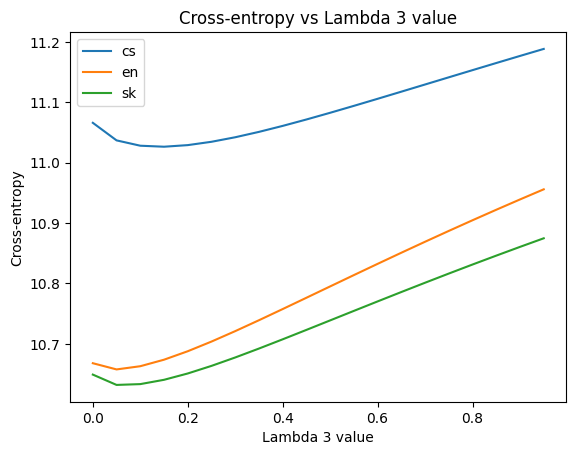

In [ ]:
lambda3_ranges = np.linspace(0,0.95,20)

def lambda3_entropy(tokens, lambdas):
    results = []
    trigrams = get_trigrams(tokens)
    bigrams = get_bigrams(tokens)
    unigrams = get_unigrams(tokens)
    N_uni = sum(unigrams.values())

    for lambda3 in lambda3_ranges:
        lambas_sum = lambdas[0] + lambdas[1] + lambdas[2] + lambda3
        ce = crossentropy(tokens, [lambdas[0] / lambas_sum, lambdas[1] / lambas_sum, lambdas[2] / lambas_sum, lambda3 / lambas_sum])
        results.append(ce)
    return results

lambda_entropies = {
    lang: lambda3_entropy(tokenized_test[lang], em_lambdas[lang]) for lang in dataset.keys()
}

import matplotlib.pyplot as plt
for lang, entropies in lambda_entropies.items():
    plt.plot(lambda3_ranges, entropies, label=lang)
plt.xlabel("Lambda 3 value")
plt.ylabel("Cross-entropy")
plt.title("Cross-entropy vs Lambda 3 value")
plt.legend()
plt.show()
